## Machine learning to create a Trading Algorithim

In this project We are trying to predict the buy and sell price for APPL using ML by using lots of variable that can impact prediction. We are aming to achive a average score that is highet then random guessig.

In [1]:
#Importing Required Libraries

import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import seaborn as sns
import hvplot.pandas
import matplotlib.pyplot as plt
import os 
from datetime import datetime, timedelta
from dotenv import load_dotenv
from alpaca_trade_api.rest import REST, TimeFrameUnit, TimeFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

Setting up API

In [2]:
load_dotenv()
#Set API and secret key
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")


Setting API Parameters to download sticker date

In [3]:
#Selecting ticker
ticker = "AAPL"

#Set timeframe
timeframe = TimeFrame(15, TimeFrameUnit.Minute)

#Setting date for latest date available from APIO
now = pd.Timestamp(datetime.now().date() - timedelta(days=2))

#Caculate the start date 
start_date = (now - timedelta(days=365*10)).date().isoformat()

#Downloading historial data from API
df_ticker = api.get_bars(
    ticker,
    timeframe,
    start=start_date,
).df

# Rename index to "Date"
df_ticker.index.name = 'Date'

In [4]:
df_ticker.head()

open    high     low   close  volume  \
Date                                                                
2015-12-01 09:00:00+00:00  118.88  118.94  118.88  118.94    1145   
2015-12-01 09:15:00+00:00  118.77  118.77  118.77  118.77     200   
2015-12-01 09:30:00+00:00  118.69  118.69  118.60  118.60     900   
2015-12-01 09:45:00+00:00  118.64  118.65  118.64  118.65    3580   
2015-12-01 10:00:00+00:00  118.65  118.65  118.55  118.55    1820   

                           trade_count        vwap  
Date                                                
2015-12-01 09:00:00+00:00            5  118.902052  
2015-12-01 09:15:00+00:00            1  118.770000  
2015-12-01 09:30:00+00:00            4  118.610000  
2015-12-01 09:45:00+00:00            5  118.648883  
2015-12-01 10:00:00+00:00            4  118.611538

### Generating the Technical Indicators and Custom trading signals by the help of the features.

In [5]:
indicators_df = pd.DataFrame()

indicators_df['Close'] = df_ticker['close']

# Calculate daily returns
indicators_df['Actual Returns'] = df_ticker['close'].pct_change()

#defining short and long window to caculaute EMA
short_window = 100
long_window = 200

# Caulcualating the EMA technical indicators for the short and long windows
indicators_df["Short"] = TA.EMA(df_ticker, short_window)
indicators_df["Long"] = TA.EMA(df_ticker, long_window)

#Caculuating the RSI indicator
indicators_df["RSI"] = TA.RSI(df_ticker)

# Calculate the upper and lower Bollinger Bands
indicators_df['20 Day MA'] = df_ticker['close'].rolling(window=20).mean()
indicators_df['Upper Band'] = indicators_df['20 Day MA'] + 2 * df_ticker['close'].rolling(window=20).std()
indicators_df['Lower Band'] = indicators_df['20 Day MA'] - 2 * df_ticker['close'].rolling(window=20).std()


In [6]:
indicators_df.head()

Close  Actual Returns       Short        Long  \
Date                                                                        
2015-12-01 09:00:00+00:00  118.94             NaN  118.940000  118.940000   
2015-12-01 09:15:00+00:00  118.77       -0.001429  118.854150  118.854575   
2015-12-01 09:30:00+00:00  118.60       -0.001431  118.767733  118.768867   
2015-12-01 09:45:00+00:00  118.65        0.000422  118.737411  118.738703   
2015-12-01 10:00:00+00:00  118.55       -0.000843  118.698415  118.700204   

                                 RSI  20 Day MA  Upper Band  Lower Band  
Date                                                                     
2015-12-01 09:00:00+00:00        NaN        NaN         NaN         NaN  
2015-12-01 09:15:00+00:00   0.000000        NaN         NaN         NaN  
2015-12-01 09:30:00+00:00   0.000000        NaN         NaN         NaN  
2015-12-01 09:45:00+00:00  14.106809        NaN         NaN         NaN  
2015-12-01 10:00:00+00:00  10.819441        NaN         NaN         NaN

#### Finding the correalation between the variables

Here we are performing the correlation matrix and visualizing them on a heat map to figure out whcih variables are less correlated.

If the correaltion:
- Is between 0.0 and -0.3, they have a week correlation.
- Is between -0.3 and -0.5 they have a moderate correlation.
- Is between 0.5 and -1 they have a high correlation.
- is between 0.0 and 0.3 they have a week correlation.
- Is between 0.3 and 0.5 they have a moderate correlation.
- Is between0.5 and 1 they have a high correlation.

<AxesSubplot:>

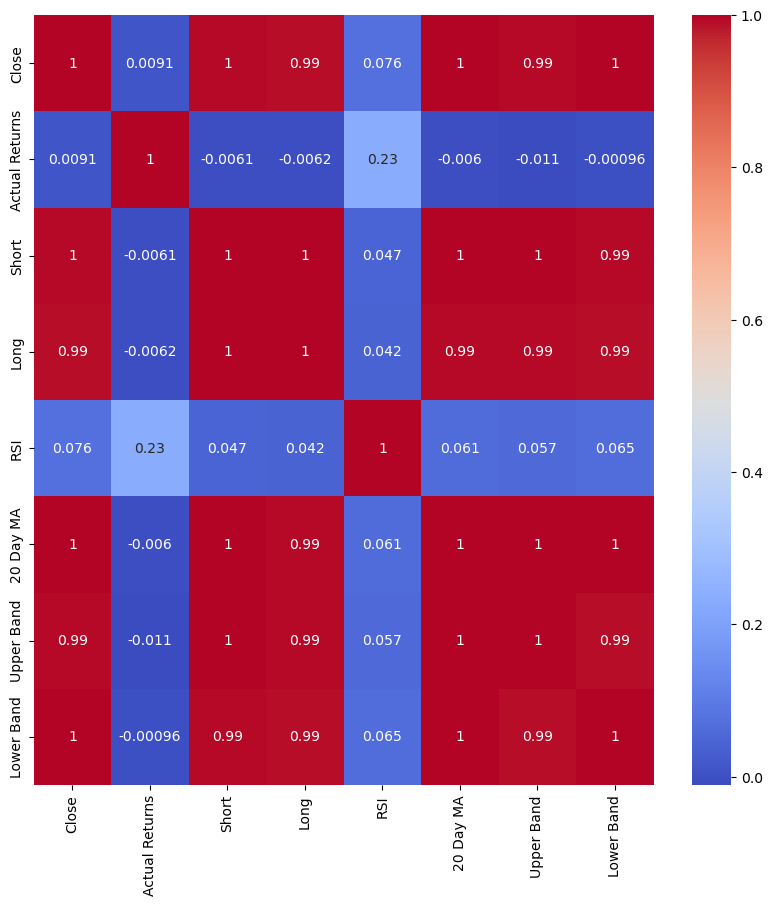

In [7]:
# Generate the correlation matrix
corr_matrix = indicators_df.dropna().corr()

# Generate the heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    corr_matrix,
    annot=True, 
    cmap='coolwarm',
    ax=ax
    )

From the corrolation map, we can see that the RSI indicator had the strongest correlation actual returns

In [8]:
#Creating new dataframe for the containing Close and RSI
rsi_indicator = pd.DataFrame()
rsi_indicator['Close'] = indicators_df['Close'].copy()
rsi_indicator['RSI'] = indicators_df["RSI"].copy()

In [9]:
# Trading Rules - buy, hold, and sell signals based on the RSI indicator
for i, row in rsi_indicator.iterrows():
    # Buy Signal
    if row['RSI'] < 30:
        rsi_indicator.loc[i, 'Buy Signal'] = 1
    # Sell Signal
    elif row['RSI'] > 70:
        rsi_indicator.loc[i, 'Buy Signal'] = -1
    else:
        # Hold
        rsi_indicator.loc[i, 'Buy Signal'] = 0

In [10]:
# Identify trade entry (1) and exit (-1) points
rsi_indicator["Entry/Exit"] = rsi_indicator["Buy Signal"].diff()

rsi_indicator["Entry/Exit"].value_counts()


 0.0    105900
 1.0      3855
-1.0      3851
-2.0         4
 2.0         2
Name: Entry/Exit, dtype: int64

In [11]:
# Visualise Backtest Peformance

exit = rsi_indicator[rsi_indicator["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color="red",
    marker="v",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400)

entry = rsi_indicator[rsi_indicator["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color="green",
    marker="^",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400)

close = rsi_indicator['Close'].hvplot(
    line_color='blue',
    ylabel="Price in $",
    width=1000,
    height=400)

rsi = rsi_indicator['RSI'].hvplot(
    line_colour = 'orange',
    ylabel="Price in $",
    width=1000,
    height=400)

# Combine plots
(entry * exit * close * rsi).opts(title='Backtest Performance')

:Overlay
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)
   .Curve.Close      :Curve   [Date]   (Close)
   .Curve.RSI        :Curve   [Date]   (RSI)

Theoretical Testing Stock Price Predictions - Caculating Profit and ROI

In [12]:
#creating data from for analysis on apple stock
appl_df = rsi_indicator.copy()

appl_df.index = appl_df.index.date

# Review the DataFrame
appl_df['Entry/Exit'].value_counts()


 0.0    105900
 1.0      3855
-1.0      3851
-2.0         4
 2.0         2
Name: Entry/Exit, dtype: int64

In [13]:
# Initialize trade_type column for buys and sells
appl_df['trade_type'] = np.nan

# Initialize a cost/proceeds column for recording trade metrics
appl_df["cost/proceeds"] = np.nan

# Initialize share_size equals 100 and accumulated_shares equals 0
share_size = 100
accumulated_shares = 0


In [14]:
# Loop through the Pandas DataFrame and code the conditions of the trading strategy
for index, row in appl_df.iterrows():

    # Buy if RSI is less than 30
    if row ['Entry/Exit'] >= 1.0:
        appl_df.loc[index, 'trade_type'] = 'buy'
        appl_df.loc[index, "cost/proceeds"] = -(row['Close'] * share_size)
        accumulated_shares += share_size
        print(f"{index}: Bought {share_size} shares, total {accumulated_shares}")

    # Sell if RSI is greater than 70
    elif row['Entry/Exit'] <= -1.0:
            if accumulated_shares > 0:
                appl_df.loc[index, 'trade_type'] = 'sell'
                appl_df.loc[index, 'cost/proceeds'] = row['Close'] * accumulated_shares
                print(f"{i}: Sold {accumulated_shares} shares at {row['Close']}")
                accumulated_shares = 0

    # else hold if RSI is between 30 and 70
    else:
        appl_df.loc[index, "trade_type"] = "hold"
    
    
    # if the index is the last index of the Dataframe, sell
    # set the cost/proceeds column equal to the row close price multiplied 
    # by the accumulated_shares
    if index == appl_df.index[-1]:
        appl_df.loc[index, "trade_type"] = "sell"
        appl_df.loc[index, "cost/proceeds"] = row["Close"] * accumulated_shares
        print(f"{index}: Sold {accumulated_shares} shares")
        accumulated_shares = 0

2015-12-01: Bought 100 shares, total 100
2023-03-14 23:45:00+00:00: Sold 100 shares at 118.72
2015-12-01: Bought 100 shares, total 100
2023-03-14 23:45:00+00:00: Sold 100 shares at 117.23
2015-12-02: Bought 100 shares, total 100
2023-03-14 23:45:00+00:00: Sold 100 shares at 117.1
2015-12-02: Bought 100 shares, total 100
2015-12-02: Bought 100 shares, total 200
2023-03-14 23:45:00+00:00: Sold 200 shares at 116.34
2015-12-03: Bought 100 shares, total 100
2023-03-14 23:45:00+00:00: Sold 100 shares at 114.8894
2015-12-04: Bought 100 shares, total 100
2023-03-14 23:45:00+00:00: Sold 100 shares at 119.03
2015-12-04: Bought 100 shares, total 100
2023-03-14 23:45:00+00:00: Sold 100 shares at 119.45
2015-12-07: Bought 100 shares, total 100
2023-03-14 23:45:00+00:00: Sold 100 shares at 119.44
2015-12-07: Bought 100 shares, total 100
2015-12-07: Bought 100 shares, total 200
2023-03-14 23:45:00+00:00: Sold 200 shares at 118.4073
2015-12-08: Bought 100 shares, total 100
2023-03-14 23:45:00+00:00: S

In [15]:
appl_df


Close        RSI  Buy Signal  Entry/Exit trade_type  \
2015-12-01  118.94        NaN         0.0         NaN       hold   
2015-12-01  118.77   0.000000         1.0         1.0       hold   
2015-12-01  118.60   0.000000         1.0         0.0       hold   
2015-12-01  118.65  14.106809         1.0         0.0       hold   
2015-12-01  118.55  10.819441         1.0         0.0       hold   
...            ...        ...         ...         ...        ...   
2023-03-14  152.58  56.358359         0.0         0.0       sell   
2023-03-14  152.68  57.935428         0.0         0.0       sell   
2023-03-14  152.68  57.935428         0.0         0.0       sell   
2023-03-14  152.74  58.967241         0.0         0.0       sell   
2023-03-14  152.77  59.502140         0.0         0.0       sell   

            cost/proceeds  
2015-12-01        11723.0  
2015-12-01        11723.0  
2015-12-01        11723.0  
2015-12-01        11723.0  
2015-12-01        11723.0  
...                   ...  
2023-03-14            0.0  
2023-03-14            0.0  
2023-03-14            0.0  
2023-03-14            0.0  
2023-03-14            0.0  

[113613 rows x 6 columns]

In [16]:
#Calculate the total profit or loss for the trading algorithm by summing the values in the "cost/proceeds" column. 

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = round(appl_df["cost/proceeds"].sum(), 2)

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss}.")

The total profit/loss of the trading strategy is $164613095.51.


In [17]:
# Calculate the ROI for the trades
# Initialize the variable to hold the value of the invested capital
invested_capital = 100

# Calculate the return on investment (ROI)
roi = float(round((total_profit_loss / (invested_capital)) * 100, 2))

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi}%")

The trading algorithm resulted in a return on investment of 164613095.51%


In [18]:
rsi_indicator['Strategy Returns'] = indicators_df['Actual Returns'] * rsi_indicator['Entry/Exit'].shift()
rsi_indicator = rsi_indicator.dropna()

display(rsi_indicator.head())
display(rsi_indicator.tail())

Close        RSI  Buy Signal  Entry/Exit  \
Date                                                                   
2015-12-01 09:30:00+00:00  118.60   0.000000         1.0         0.0   
2015-12-01 09:45:00+00:00  118.65  14.106809         1.0         0.0   
2015-12-01 10:00:00+00:00  118.55  10.819441         1.0         0.0   
2015-12-01 10:15:00+00:00  118.60  20.762194         1.0         0.0   
2015-12-01 10:30:00+00:00  118.50  16.741914         1.0         0.0   

                           Strategy Returns  
Date                                         
2015-12-01 09:30:00+00:00         -0.001431  
2015-12-01 09:45:00+00:00          0.000000  
2015-12-01 10:00:00+00:00         -0.000000  
2015-12-01 10:15:00+00:00          0.000000  
2015-12-01 10:30:00+00:00         -0.000000

Close        RSI  Buy Signal  Entry/Exit  \
Date                                                                   
2023-03-14 22:45:00+00:00  152.58  56.358359         0.0         0.0   
2023-03-14 23:00:00+00:00  152.68  57.935428         0.0         0.0   
2023-03-14 23:15:00+00:00  152.68  57.935428         0.0         0.0   
2023-03-14 23:30:00+00:00  152.74  58.967241         0.0         0.0   
2023-03-14 23:45:00+00:00  152.77  59.502140         0.0         0.0   

                           Strategy Returns  
Date                                         
2023-03-14 22:45:00+00:00              -0.0  
2023-03-14 23:00:00+00:00               0.0  
2023-03-14 23:15:00+00:00               0.0  
2023-03-14 23:30:00+00:00               0.0  
2023-03-14 23:45:00+00:00               0.0

<AxesSubplot:xlabel='Date'>

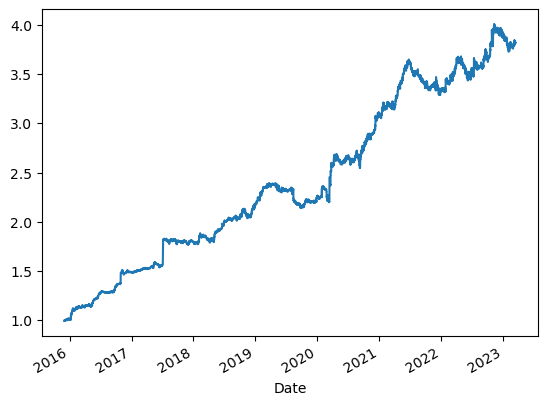

In [19]:
(1 + rsi_indicator['Strategy Returns']).cumprod().plot()


In [20]:
# Assign a copy of the RSI columns to a features DataFrame called X 
X = rsi_indicator[['RSI']].shift().dropna()

# Assign Buy Signals columns to a features DataFrame called Y
y = rsi_indicator['Buy Signal']
display(X.head())
display(y.value_counts())

RSI
Date                                
2015-12-01 09:45:00+00:00   0.000000
2015-12-01 10:00:00+00:00  14.106809
2015-12-01 10:15:00+00:00  10.819441
2015-12-01 10:30:00+00:00  20.762194
2015-12-01 10:45:00+00:00  16.741914

 0.0    98298
-1.0     8853
 1.0     6460
Name: Buy Signal, dtype: int64

### Split the data into training and testing using time series split

In [21]:
# Select the start of the training period
training_begin = X.index.min()

# Select the ending period for the training data with an offset of 12 months
training_end = X.index.min() + DateOffset(months=12)


In [22]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

RSI
Date                                
2015-12-01 09:45:00+00:00   0.000000
2015-12-01 10:00:00+00:00  14.106809
2015-12-01 10:15:00+00:00  10.819441
2015-12-01 10:30:00+00:00  20.762194
2015-12-01 10:45:00+00:00  16.741914

In [23]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

RSI
Date                                
2016-12-01 11:00:00+00:00  32.735335
2016-12-01 11:15:00+00:00  32.471814
2016-12-01 11:30:00+00:00  28.088649
2016-12-01 11:45:00+00:00  28.088649
2016-12-01 12:00:00+00:00  26.918093

Scacling the Data

In [24]:

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

As we want to predictBuy/sell Signal, we will go ahead with the classification approach and use SVC classifier from SKLearns Ssupport vector machine (SVM) learning method o fit the training data and make predictions based on the testing data.

In [25]:
# From SVM, instantiate SVC classifier model instance
svm_model = SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_train_scaled)

# Review the model's predicted values
print(svm_pred)

[1. 1. 1. ... 0. 0. 0.]


#### Review the classification report associated with the `SVC` model predictions. 

In [26]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_train, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.78      0.68      0.72       969
         0.0       0.95      0.97      0.96     13100
         1.0       0.78      0.71      0.74       974

    accuracy                           0.93     15043
   macro avg       0.84      0.78      0.81     15043
weighted avg       0.93      0.93      0.93     15043



In [38]:
len(svm_pred)

15043

#### Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [27]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
svm_predictions_df = pd.DataFrame(index=y_train.index)

# Add the SVM model predictions to the DataFrame
svm_predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
svm_predictions_df['Actual Returns'] = indicators_df['Actual Returns']

# Add the strategy returns to the DataFrame
svm_predictions_df['Strategy Returns'] = svm_predictions_df['Actual Returns'] * svm_predictions_df['Predicted']

# Review the DataFrame
display(svm_predictions_df.head())
display(svm_predictions_df.tail())

Predicted  Actual Returns  Strategy Returns
Date                                                                  
2015-12-01 09:45:00+00:00        1.0        0.000422          0.000422
2015-12-01 10:00:00+00:00        1.0       -0.000843         -0.000843
2015-12-01 10:15:00+00:00        1.0        0.000422          0.000422
2015-12-01 10:30:00+00:00        1.0       -0.000843         -0.000843
2015-12-01 10:45:00+00:00        1.0        0.001857          0.001857

Predicted  Actual Returns  Strategy Returns
Date                                                                  
2016-12-01 00:00:00+00:00        0.0       -0.000452              -0.0
2016-12-01 00:15:00+00:00        0.0        0.000000               0.0
2016-12-01 00:30:00+00:00        0.0        0.000543               0.0
2016-12-01 00:45:00+00:00        0.0        0.000000               0.0
2016-12-01 09:15:00+00:00        0.0       -0.003705              -0.0

#### Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

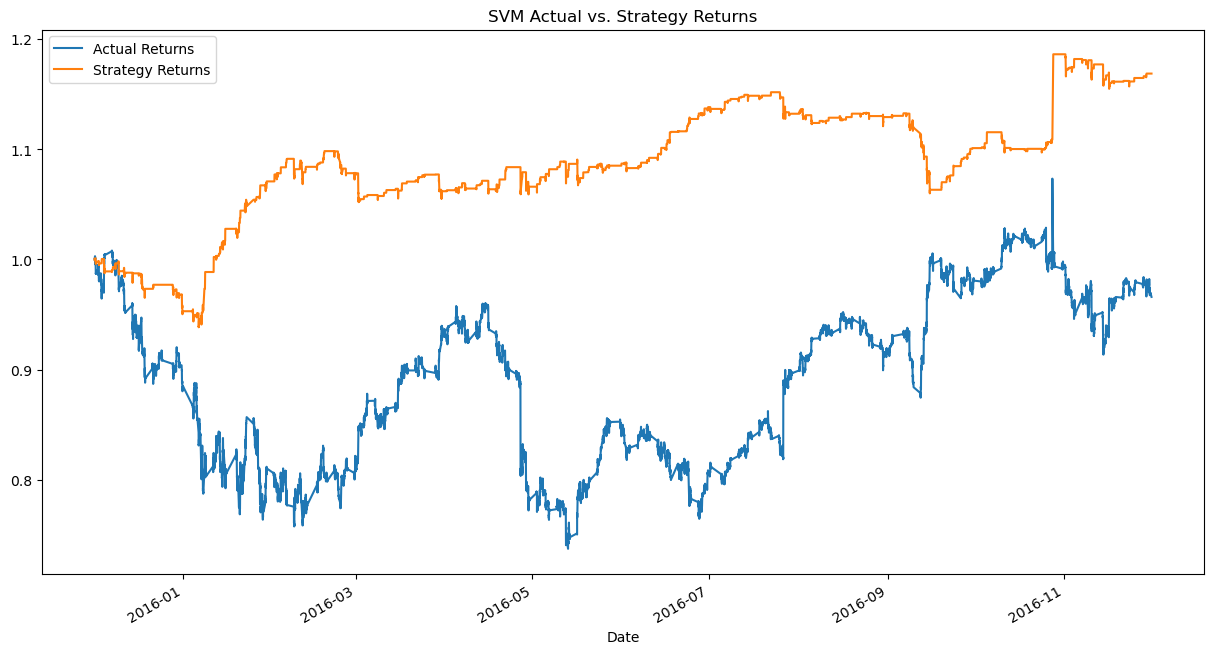

<Figure size 640x480 with 0 Axes>

In [28]:
# Plot the actual returns versus the strategy returns
((1 + svm_predictions_df[['Actual Returns', 'Strategy Returns']]
  .cumsum())
 .plot(figsize=(15, 8)))
plt.title('SVM Actual vs. Strategy Returns')
plt.show()

plt.savefig('SVM Actual vs. Strategy Returns.png')

#### Backtesting a Machine Learning Trading Algorithm

In [29]:
# Use the trained model to predict the trading signals for the testing data.
svm_testing_signal_predictions = svm_model.predict(X_test_scaled)

print(svm_testing_signal_predictions)

[0. 0. 1. ... 0. 0. 0.]


In [30]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, svm_testing_signal_predictions)

# Display the report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.80      0.68      0.73      7884
         0.0       0.95      0.97      0.96     85198
         1.0       0.76      0.69      0.72      5485

    accuracy                           0.93     98567
   macro avg       0.83      0.78      0.80     98567
weighted avg       0.93      0.93      0.93     98567



#### Create a predictions DataFrame from back testing that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [31]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
svm_backtest_predictions_df = pd.DataFrame(index=y_test.index)

# Add the SVM model predictions to the DataFrame
svm_backtest_predictions_df['Predicted'] = svm_testing_signal_predictions

# Add the actual returns to the DataFrame
svm_backtest_predictions_df['Actual Returns'] = indicators_df['Actual Returns']

# Add the strategy returns to the DataFrame
svm_backtest_predictions_df['Strategy Returns'] = svm_backtest_predictions_df['Actual Returns'] * svm_backtest_predictions_df['Predicted']

# Review the DataFrame
display(svm_backtest_predictions_df.head())
display(svm_backtest_predictions_df.tail())

Predicted  Actual Returns  Strategy Returns
Date                                                                  
2016-12-01 11:00:00+00:00        0.0       -0.000091         -0.000000
2016-12-01 11:15:00+00:00        0.0       -0.001633         -0.000000
2016-12-01 11:30:00+00:00        1.0        0.000000          0.000000
2016-12-01 11:45:00+00:00        1.0       -0.000454         -0.000454
2016-12-01 12:00:00+00:00        1.0        0.000000          0.000000

Predicted  Actual Returns  Strategy Returns
Date                                                                  
2023-03-14 22:45:00+00:00        0.0       -0.000328              -0.0
2023-03-14 23:00:00+00:00        0.0        0.000655               0.0
2023-03-14 23:15:00+00:00        0.0        0.000000               0.0
2023-03-14 23:30:00+00:00        0.0        0.000393               0.0
2023-03-14 23:45:00+00:00        0.0        0.000196               0.0

#### Create a cumulative return plot that shows the backtested actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

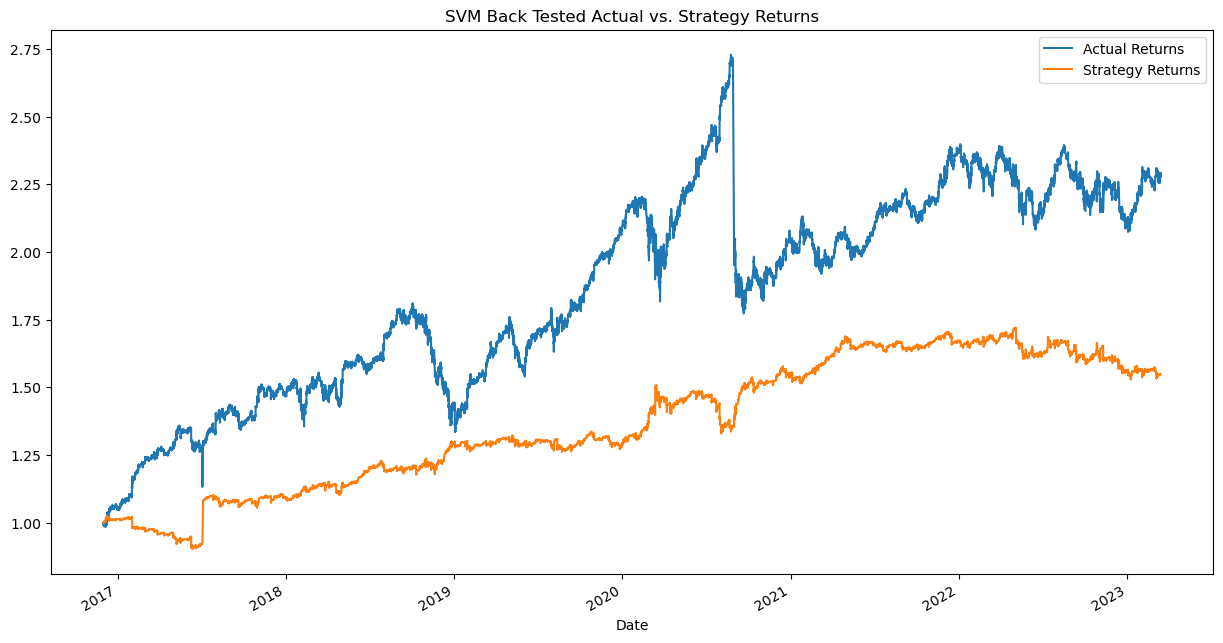

In [32]:
# Plot the actual returns versus the strategy returns
((1 + svm_backtest_predictions_df[['Actual Returns', 'Strategy Returns']]
  .cumsum())
 .plot(figsize=(15, 8)))
plt.title('SVM Back Tested Actual vs. Strategy Returns')
plt.show()


### Using Alternative mode to see if we can achive higher average score

In [33]:
# Instantiate the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_scaled, y_train)

# Use the model to make predictions on the testing data
rf_pred = rf_model.predict(X_train_scaled)

print(rf_pred)

[1. 1. 1. ... 0. 0. 0.]


In [34]:
# Use a classification report to evaluate the model using the predictions and testing data
rf_testing_report_train = classification_report(y_train, rf_pred)

# Print the classification report
print(rf_testing_report_train)

              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.99       969
         0.0       1.00      1.00      1.00     13100
         1.0       0.99      0.98      0.99       974

    accuracy                           1.00     15043
   macro avg       0.99      0.99      0.99     15043
weighted avg       1.00      1.00      1.00     15043



In [37]:
len(rf_pred)

15043

In [40]:
# Create a new empty predictions DataFrame:
# Create a predictions DataFrame
rf_predictions_df = pd.DataFrame(index=y_train.index)

# Add the SVM model predictions to the DataFrame
rf_predictions_df['Predicted'] = rf_pred

# Add the actual returns to the DataFrame
rf_predictions_df['Actual Returns'] = indicators_df['Actual Returns']

# Add the strategy returns to the DataFrame
rf_predictions_df['Strategy Returns'] = rf_predictions_df['Actual Returns'] * rf_predictions_df['Predicted']


# Review the DataFrame
display(rf_predictions_df.head())
display(rf_predictions_df.tail())

Predicted  Actual Returns  Strategy Returns
Date                                                                  
2015-12-01 09:45:00+00:00        1.0        0.000422          0.000422
2015-12-01 10:00:00+00:00        1.0       -0.000843         -0.000843
2015-12-01 10:15:00+00:00        1.0        0.000422          0.000422
2015-12-01 10:30:00+00:00        1.0       -0.000843         -0.000843
2015-12-01 10:45:00+00:00        0.0        0.001857          0.000000

Predicted  Actual Returns  Strategy Returns
Date                                                                  
2016-12-01 00:00:00+00:00        0.0       -0.000452              -0.0
2016-12-01 00:15:00+00:00        0.0        0.000000               0.0
2016-12-01 00:30:00+00:00        0.0        0.000543               0.0
2016-12-01 00:45:00+00:00        0.0        0.000000               0.0
2016-12-01 09:15:00+00:00        0.0       -0.003705              -0.0

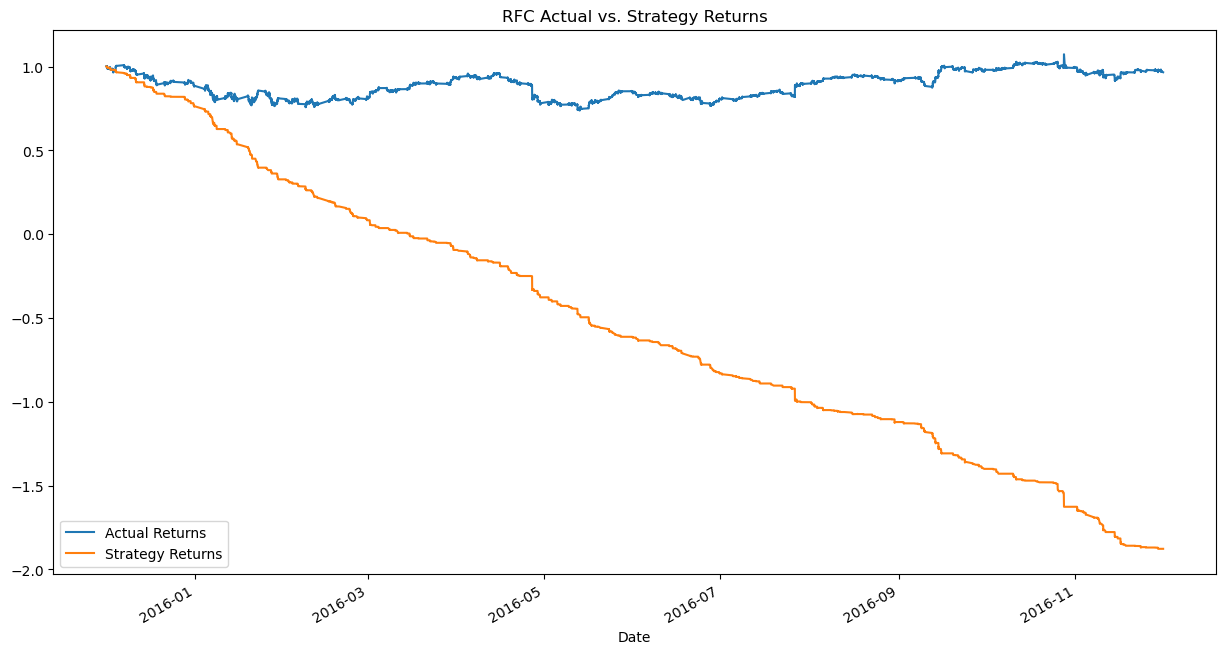

In [41]:
# Plot the actual returns versus the strategy returns
((1 + rf_predictions_df[['Actual Returns', 'Strategy Returns']]
  .cumsum())
 .plot(figsize=(15, 8)))
plt.title('RFC Actual vs. Strategy Returns')
plt.show()

## Back Testing

In [ ]:
# Use the trained model to predict the trading signals for the testing data.
rf_backtesting_signal_predictions = rf_model.predict(X_test_scaled)

In [ ]:
# Evaluate the model's ability to predict the trading signal for the testing data
rf_backtesting_report_test = classification_report(y_test, rf_backtesting_signal_predictions)

# Display the report
print(rf_backtesting_signal_predictions)

[0. 0. 1. ... 0. 0. 0.]


In [ ]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
rf_backtest_predictions_df = pd.DataFrame(index=y_test.index)

# Add the SVM model predictions to the DataFrame
rf_backtest_predictions_df['Predicted'] = rf_backtesting_signal_predictions

# Add the actual returns to the DataFrame
rf_backtest_predictions_df['Actual Returns'] = indicators_df['Actual Returns']

# Add the strategy returns to the DataFrame
rf_backtest_predictions_df['Strategy Returns'] = rf_backtest_predictions_df['Actual Returns'] * rf_backtest_predictions_df['Predicted']

# Review the DataFrame
display(rf_backtest_predictions_df.head())
display(rf_backtest_predictions_df.tail())


Predicted  Actual Returns  Strategy Returns
Date                                                                  
2016-12-01 11:00:00+00:00        0.0       -0.000091         -0.000000
2016-12-01 11:15:00+00:00        0.0       -0.001633         -0.000000
2016-12-01 11:30:00+00:00        1.0        0.000000          0.000000
2016-12-01 11:45:00+00:00        1.0       -0.000454         -0.000454
2016-12-01 12:00:00+00:00        1.0        0.000000          0.000000

Predicted  Actual Returns  Strategy Returns
Date                                                                  
2023-03-14 22:45:00+00:00        0.0       -0.000328              -0.0
2023-03-14 23:00:00+00:00        0.0        0.000655               0.0
2023-03-14 23:15:00+00:00        0.0        0.000000               0.0
2023-03-14 23:30:00+00:00        0.0        0.000393               0.0
2023-03-14 23:45:00+00:00        0.0        0.000196               0.0

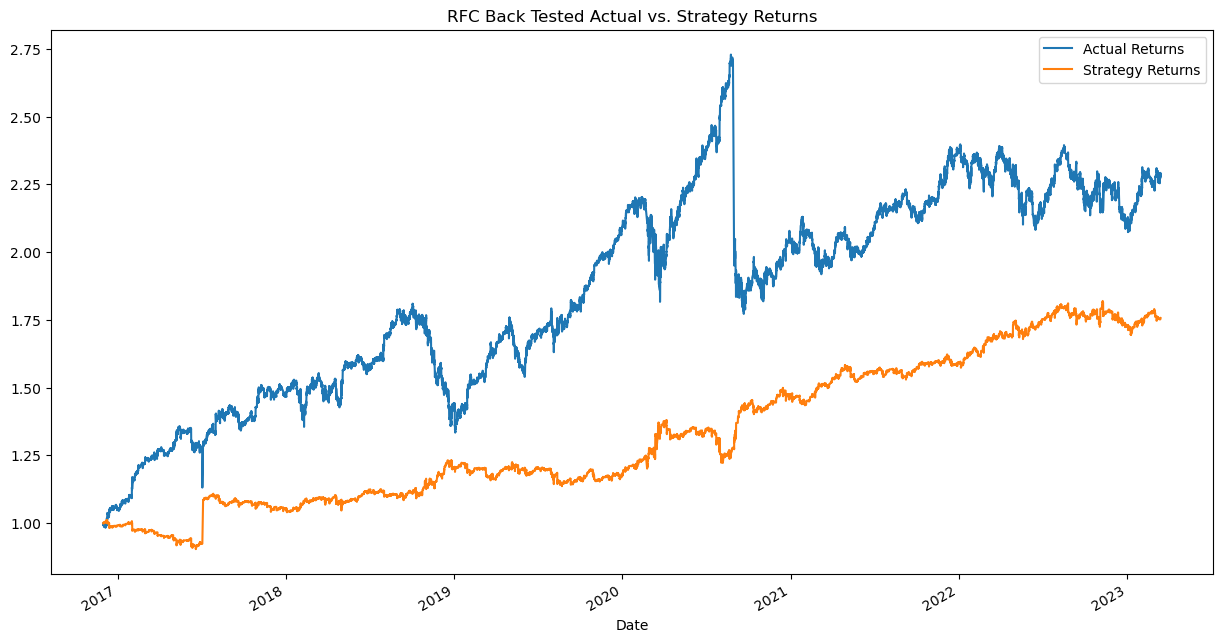

In [ ]:
# Plot the actual returns versus the strategy returns
((1 + rf_backtest_predictions_df[['Actual Returns', 'Strategy Returns']]
  .cumsum())
 .plot(figsize=(15, 8)))
plt.title('RFC Back Tested Actual vs. Strategy Returns')
plt.show()
